# Analyse des données

ce notebook sert a analysé les données de training 

# Import des données et des packages

In [ ]:
import os
import sys
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,optimizer=None,device=cpu,floatX=float32"
sys.path = [p for p in sys.path if ".local/lib/python3.8/site-packages" not in p]
import numpy as np
import matplotlib.pyplot as plt

import lasagne
import theano
from mypackage.building_models import build_model_from_name

import umap
from sklearn.preprocessing import StandardScaler

data = np.load("./data/train.npz")
test = np.load("./data/test.npz")
print(f"taille du jeu de donnée d'entrainement : {len(data['X_train'])}")
print(f"taille du jeu de donnée de test : {len(test['X_test'])}")

taille du jeu de donnée d'entrainement : 4763
taille du jeu de donnée de test : 1195


In [3]:
X_train = data["X_train"]
y_train = data["y_train"]

X = np.concatenate([data["X_train"], test["X_test"]], axis=0)
y = np.concatenate([data["y_train"], test["y_test"]], axis=0)

In [4]:
print("Shape de X :", X.shape)
print("Shape de y :", y.shape)

Shape de X : (5958, 1000, 20)
Shape de y : (5958,)


## Build le network

tu peux remplacer tes hyperparametre par ceux de ton model

In [6]:
_, val_fn, l_out = build_model_from_name(
        model_name="CNN-LSTM",
        X_train=X_train,
        y_train=y_train,
        batch_size=32,
        n_hid=64,
        n_filt=64,
        lr=0.0005,
        drop_prob=0.5
    )

## Load this model

trouve les poids du model que tu veux charger

In [18]:
params = np.load("models/101_CNN-LSTM.npz", allow_pickle=True)
weights = [params[f"arr_{i}"] for i in range(len(params.files))]
lasagne.layers.set_all_param_values(l_out, weights)

In [19]:
layers = lasagne.layers.get_all_layers(l_out)
l_dense = [L for L in layers if L.name == "Dense"][0]

In [25]:
from theano.gof.graph import inputs as graph_inputs

input_var = layers[0].input_var

embedding_expr = lasagne.layers.get_output(
    l_dense,
    deterministic=True
)
free_vars = [v for v in graph_inputs([embedding_expr]) if v.owner is None]
mask_var = [v for v in free_vars if v.name == "masks"][0]

get_embedding = theano.function(
    [input_var, mask_var],
    embedding_expr,
    allow_input_downcast=True
)

In [ ]:
def extract_embeddings(X, mask, batch_size=32):
    Z_list = []
    n_full = (X.shape[0] // batch_size) * batch_size

    for i in range(0, n_full, batch_size):
        xb = X[i:i+batch_size]
        mb = mask[i:i+batch_size]
        Z_batch = get_embedding(xb, mb)
        Z_list.append(Z_batch)

    return np.vstack(Z_list)


Z = extract_embeddings(X_train, data["mask_train"])
print(Z.shape)


(4736, 128)


## Compile la UMAP et trace la 

In [30]:
Z_scaled = StandardScaler().fit_transform(Z)
umap_model = umap.UMAP(
    n_neighbors=15,    
    min_dist=0.1,        
    metric="euclidean",  
    random_state=42
)
X_umap = umap_model.fit_transform(Z_scaled)

/home/owen/miniconda3/envs/theano/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [33]:
%matplotlib inline

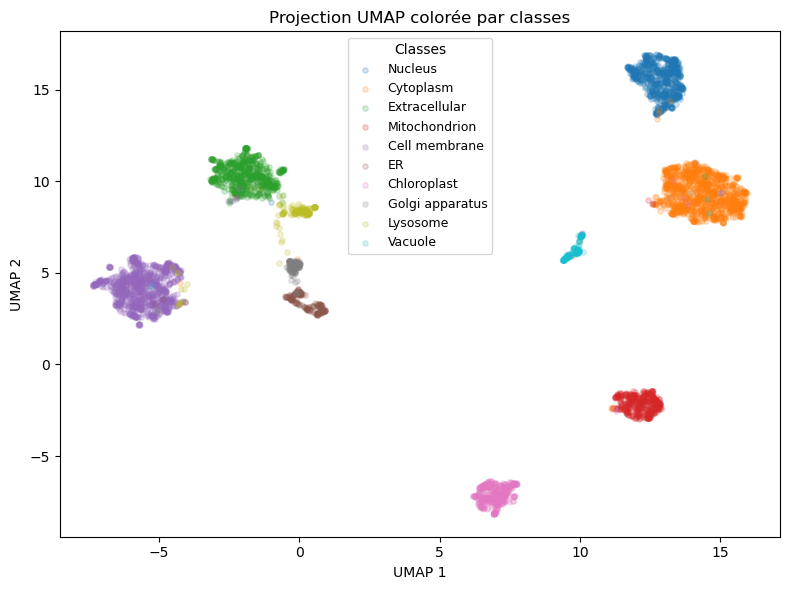

In [ ]:
classes = ['Nucleus','Cytoplasm','Extracellular','Mitochondrion','Cell membrane','ER',
           'Chloroplast','Golgi apparatus','Lysosome','Vacuole']
n_umap = X_umap.shape[0]
y_umap = y_train[:n_umap]

cmap = plt.get_cmap("tab10")

plt.figure(figsize=(8, 6))

for class_id, class_name in enumerate(classes):
    mask = (y_umap == class_id)
    
    plt.scatter(
        X_umap[mask, 0],
        X_umap[mask, 1],
        s=15,
        color=cmap(class_id),
        label=class_name,
        alpha=0.2
    )

plt.title("Projection UMAP colorée par classes")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Légende propre
plt.legend(title="Classes", loc="best", fontsize=9)

plt.tight_layout()
plt.show()